In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [2]:
!wget https://raw.githubusercontent.com/plotly/datasets/master/tesla-stock-price.csv -O dataset.csv

--2025-11-20 05:45:36--  https://raw.githubusercontent.com/plotly/datasets/master/tesla-stock-price.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55371 (54K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]  54.07K  --.-KB/s    in 0.04s   

2025-11-20 05:45:36 (1.32 MB/s) - ‘dataset.csv’ saved [55371/55371]



In [3]:
df = pd.read_csv("dataset.csv")
print(df.head())
print(df.shape)

         date   close         volume    open    high       low
0       11:34  270.49      4,787,699  264.50  273.88  262.2400
1  2018/10/15  259.59   6189026.0000  259.06  263.28  254.5367
2  2018/10/12  258.78   7189257.0000  261.00  261.99  252.0100
3  2018/10/11  252.23   8128184.0000  257.53  262.25  249.0300
4  2018/10/10  256.88  12781560.0000  264.61  265.51  247.7700
(757, 6)


In [4]:
df = df.sort_values("date")
df['next_day_close'] = df['close'].shift(-1)
df = df.dropna()  # Remove any missing values

# Clean up the 'volume' column by removing commas and converting to numeric
df['volume'] = df['volume'].astype(str).str.replace(',', '', regex=False)
df['volume'] = pd.to_numeric(df['volume'])


# Keep all features except 'date' and 'next_day_close' as inputs
features = df.drop(["date", "next_day_close"], axis=1)
target = df["next_day_close"]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

In [9]:
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_sequences(scaled_features, scaled_target, time_steps)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (696, 60, 5)
Shape of y: (696, 1)


In [10]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [11]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,901 (499.61 KB)

 Trainable params: 127,901 (499.61 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0380 - val_loss: 0.0177
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0323 - val_loss: 0.0088
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0481 - val_loss: 0.0142
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0182 - val_loss: 0.0060
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


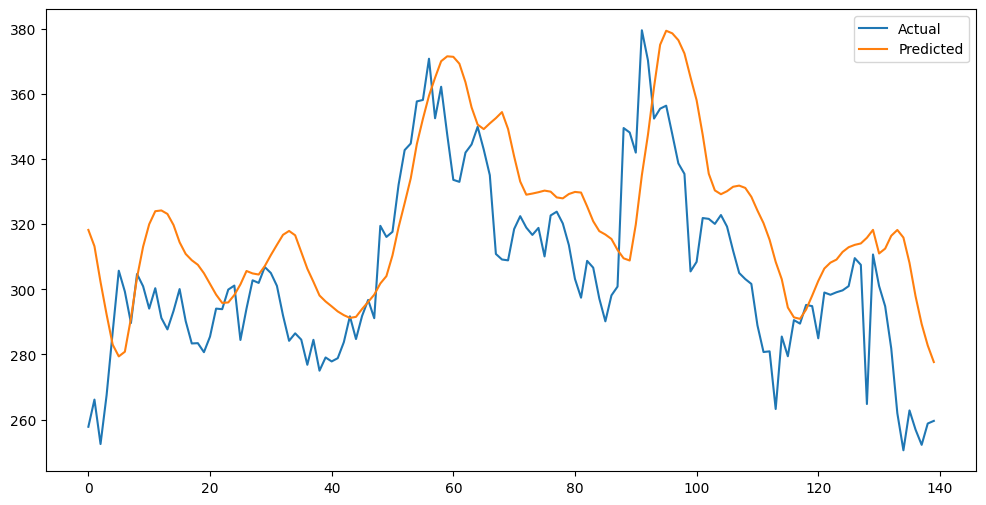

RMSE: 24.867467331234547


In [13]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print("RMSE:", rmse)


In [14]:
model.save("tesla_lstm_model.h5")

In [15]:
last_60_days = scaled_features[-60:]
X_future = np.array([last_60_days])
predicted_price = model.predict(X_future)
predicted_price = scaler.inverse_transform(predicted_price)
print("Predicted Next Day Close:", predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Next Day Close: 274.88947
